# Data Intern Challenge - Stone

This notebook was created to solve the data challenge for intern applicants.

The questions/requirements will be explained as we go.

## Imports and database connection

First, some libraries will be imported and the connection with the database will be created.

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
connection = psycopg2.connect(
    database="postgres",
    user="read_only_user",
    password="banking123",
    host="db-stone.cjepwwjnksng.us-east-1.rds.amazonaws.com",
    port='5432'
)

In [3]:
cursor = connection.cursor()
# Display the PostgreSQL version installed
cursor.execute("SELECT version();")
record = cursor.fetchone()
print("You are connected into the - ", record,"\n")

You are connected into the -  ('PostgreSQL 11.5 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.3 20140911 (Red Hat 4.8.3-9), 64-bit',) 



## First exercise

1. Extract and analyze the data in the database in order to answer the following questions. Provide a description and/or comments for each solution.

- What is the average `age` of the customers in the database?

To answer this question, we will first import the `customers` table into a DataFrame, then take a look in its columns.

In [4]:
customers = pd.read_sql("SELECT * FROM CUSTOMERS", connection)
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5674 entries, 0 to 5673
Data columns (total 4 columns):
id               5674 non-null object
age              5674 non-null int64
segment          5674 non-null object
vintage_group    5674 non-null object
dtypes: int64(1), object(3)
memory usage: 177.4+ KB


In [5]:
customers.head()

,id,age,segment,vintage_group
0,CC25034,35,Diamond,VG1
1,CC59625,22,Diamond,VG1
2,CC69314,33,Diamond,VG1
3,CC67036,46,Diamond,VG1
4,CC25597,44,Diamond,VG1


Now that we know its columns, we can calculate the average age on this database.

In [6]:
print("The average age of the customers in the database is", np.average(customers.age))

The average age of the customers in the database is 35.059922453295734


It is interesting to see that the average age is lower than the average age of the brazilian entrepreneur, which is 44.7 years old according to SEBRAE (https://datasebrae.com.br/perfil-dos-empresarios/, data from 2016). This may indicate that the Conta Stone public is, in general, younger.

To have a better understanding of the age distribution, we can see the percentiles below:

In [7]:
customers.age.describe()

count    5674.000000
mean       35.059922
std         8.962637
min        20.000000
25%        27.000000
50%        35.000000
75%        43.000000
max        50.000000
Name: age, dtype: float64

The percentiles show that 75% of the dataset has 43 years old or less and the older person has 50, which shows that the public really is younger. One possible explanation for this is that older entrepreneurs still look for the traditional banks instead going for a more technological and client oriented one, because they feel safer.

Obs: alternative query to get the result directly: `SELECT AVG(age) FROM customers`

- How is the `card_family` ranked based on the `credit_limit` given to each card?

For this question, we will analyze the information on the other tables first.

In [8]:
cards = pd.read_sql("SELECT * FROM cards", connection)
transactions = pd.read_sql("SELECT * FROM transactions", connection)
frauds = pd.read_sql("SELECT * FROM frauds", connection)

In [188]:
# Closing the database connection since all tables are already loaded in DataFrames
cursor.close()
connection.close()
print("PostgreSQL connection is now closed")

PostgreSQL connection is now closed


In [9]:
cards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
card_number     500 non-null object
card_family     500 non-null object
credit_limit    500 non-null int64
customer_id     500 non-null object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


In [10]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
id                  10000 non-null object
card_number         10000 non-null object
transaction_date    10000 non-null object
value               10000 non-null int64
segment             10000 non-null object
dtypes: int64(1), object(4)
memory usage: 390.8+ KB


In [11]:
transactions['transaction_date'] = pd.to_datetime(transactions.transaction_date)

In [12]:
frauds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 2 columns):
transaction_id    109 non-null object
fraud_flag        109 non-null bool
dtypes: bool(1), object(1)
memory usage: 1.1+ KB


The information that we want is only on the cards table, therefore we will explore this table now:

In [13]:
cards.head()

,card_number,card_family,credit_limit,customer_id
0,8638-5407-3631-8196,Premium,530000,CC67088
1,7106-4239-7093-1515,Gold,18000,CC12076
2,6492-5655-8241-3530,Premium,596000,CC97173
3,2868-5606-5152-5706,Gold,27000,CC55858
4,1438-6906-2509-8219,Platinum,142000,CC90518


In [14]:
cards_grouped_by_family = cards[['card_family', 'credit_limit']].groupby('card_family')

In [15]:
cards_grouped_by_family.describe()

credit_limit                                                    \
                   count           mean            std       min       25%   
card_family                                                                  
Gold               181.0   27878.453039   13495.127921    2000.0   17000.0   
Platinum           112.0  131294.642857   43272.369811   51000.0  101500.0   
Premium            207.0  514763.285024  232013.740397  108000.0  325000.0   

                                           
                  50%       75%       max  
card_family                                
Gold          28000.0   38000.0   50000.0  
Platinum     136500.0  166250.0  200000.0  
Premium      516000.0  710000.0  899000.0

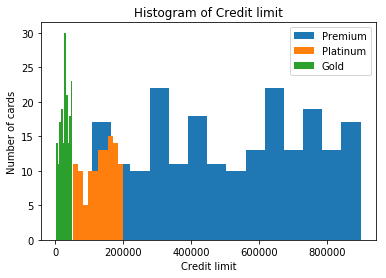

In [16]:
plt.title('Histogram of Credit limit')
plt.xlabel('Credit limit')
plt.ylabel('Number of cards')
plt.hist(cards[cards.card_family == 'Premium']['credit_limit'].values, label='Premium', bins=14)
plt.hist(cards[cards.card_family == 'Platinum']['credit_limit'].values, label='Platinum')
plt.hist(cards[cards.card_family == 'Gold']['credit_limit'].values, label='Gold')
plt.legend(loc='best')
plt.show()

With the plot we can see the `family_card` ranking given the `credit_limit`. In general: `Gold < Platinum < Premium`.

For Gold, the maximun value is smaller than the smaller value for Platinum, therefore the division between them is easier to identify. When comparing Platinum and Premium, there is a overlap in a area of the graph, but  more than 75% of the Premium cards have greater limit than the maximun Platinum limit. Besides that, the Premium maximun value and the Premium range of values are way greater than the Platinum.

- For the transactions flagged as fraud, what are the `id`s of the transactions with the highest value?

For this question, we need to join the `transactions` table with the `frauds`.

In [17]:
frauds.fraud_flag.unique()

array([ True])

In [18]:
fraud_transactions = frauds.merge(transactions, left_on='transaction_id', right_on='id')
fraud_transactions.head()

,transaction_id,fraud_flag,id,card_number,transaction_date,value,segment
0,CTID50558449,True,CTID50558449,4246-1369-3659-8804,2016-05-06,6984,SEG23
1,CTID55936882,True,CTID55936882,1336-9200-1264-2551,2016-11-29,34367,SEG21
2,CTID63762180,True,CTID63762180,8528-6154-7390-5081,2016-12-05,44550,SEG15
3,CTID76723439,True,CTID76723439,7908-2695-7391-7499,2016-09-15,48275,SEG16
4,CTID21246201,True,CTID21246201,2524-4184-5908-6750,2016-02-29,35751,SEG25


In [19]:
highest_value_fraud = fraud_transactions[fraud_transactions.value == fraud_transactions.value.max()]
highest_value_fraud

,transaction_id,fraud_flag,id,card_number,transaction_date,value,segment
6,CTID20567160,True,CTID20567160,3295-6390-4452-7199,2016-10-08,49155,SEG16


In [20]:
print("The transaction id flagged as fraud with the highest value is:", highest_value_fraud['id'].values[0])

The transaction id flagged as fraud with the highest value is: CTID20567160


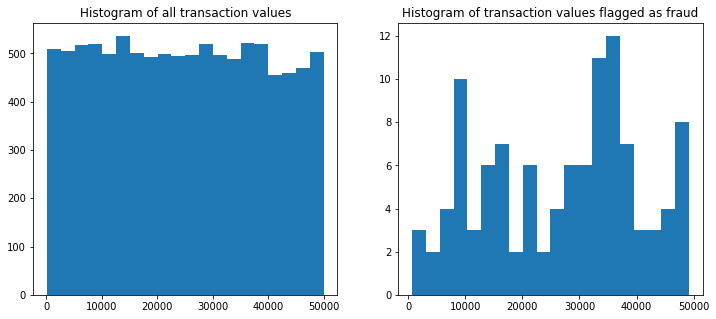

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].set_title('Histogram of all transaction values')
axs[0].hist(transactions.value, bins=20)
axs[1].set_title('Histogram of transaction values flagged as fraud')
axs[1].hist(fraud_transactions.value, bins=20)
plt.show()

While the transactions value distribution tends to be uniform, the value of flagged transactions is a little more random, with two bigger peaks: one around 10000 and another around 35000.

## Second exercise

2. Analysis:

    - Analyze whether or not the fraudulent transactions are somehow associated to the other features of the dataset. Explain your results.
    
The facilitate the analysis, first, we will get all the important information in the same dataset. The chosen variables are:

- `cards`:
    - `card_family`
    - `credit_limit` (both variables are correlated, but, because of the overlap on Platinum and Premium, it was decided to keep both and pay attention to it)
- `customers`:
    - `age`
    - `segment` (that is equivalent to `vintage_group` as shown in the next cell)
- `transactions`:
    - `transaction_date` (actually, it will be extracted the day, the day of the week and the month)
    - `value`
    - `segment`
- `frauds`:
    - `fraud_flag`

Ids and numbers will be used just to join the tables.

In [22]:
# Showing that segment and vintage_group are equivalente in the dataset)
customers.groupby('segment').vintage_group.describe()

,count,unique,top,freq
segment,,,,
Diamond,2524,1,VG1,2524
Gold,1839,1,VG3,1839
Platinum,1311,1,VG2,1311


In [23]:
transactions_with_fraud_flags = pd.merge(transactions, frauds, left_on='id', right_on='transaction_id', how='left')
# transactions_with_fraud_flags.head()

In [24]:
# Adjusting the added variables before next merge
transactions_with_fraud_flags['fraud_flag'].fillna(False, inplace=True)
transactions_with_fraud_flags_treated = transactions_with_fraud_flags.drop(columns=['transaction_id'])
# transactions_with_fraud_flags_treated.head()

In [25]:
transaction_with_fraud_and_card = pd.merge(transactions_with_fraud_flags_treated, cards, on='card_number')
# transaction_with_fraud_and_card.head()

In [26]:
transaction_with_fraud_card_and_customers = pd.merge(transaction_with_fraud_and_card, customers, left_on='customer_id', right_on='id', suffixes=['','_customer'])
# transaction_with_fraud_card_and_customers.head()

In [27]:
# Dropping unnecessary variables
transactions_aux = transaction_with_fraud_card_and_customers.drop(columns=['id', 'card_number', 'customer_id', 'id_customer', 'vintage_group'])
# transactions_aux.head()

In [28]:
transactions_aux['day'] = transactions_aux.transaction_date.apply(lambda date: date.day)
transactions_aux['weekday'] = transactions_aux.transaction_date.apply(lambda date: date.day_name())
transactions_aux['month'] = transactions_aux.transaction_date.apply(lambda date: date.month)
transactions_analysis = transactions_aux.drop(columns=['transaction_date'])
transactions_analysis.head()

,value,segment,fraud_flag,card_family,credit_limit,age,segment_customer,day,weekday,month
0,23649,SEG25,False,Platinum,194000,23,Gold,24,Sunday,4
1,48307,SEG17,False,Platinum,194000,23,Gold,16,Saturday,1
2,14032,SEG25,False,Platinum,194000,23,Gold,27,Wednesday,4
3,11063,SEG24,False,Platinum,194000,23,Gold,5,Tuesday,7
4,47956,SEG18,False,Platinum,194000,23,Gold,30,Sunday,10


With the variables in the same dataframe and with the date features created, we can take a closer look in each one of them. First, it will be studied the day, weekday and month:

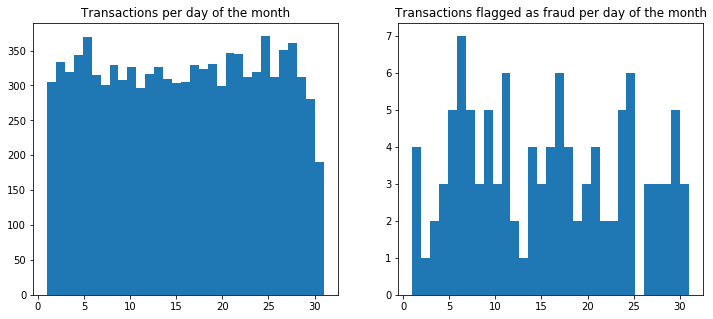

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].set_title('Transactions per day of the month')
axs[0].hist(transactions_analysis[(transactions_analysis.fraud_flag == False)].day, bins=len(transactions_analysis.day.unique()))
axs[1].set_title('Transactions flagged as fraud per day of the month')
axs[1].hist(transactions_analysis[(transactions_analysis.fraud_flag == True)].day, bins=len(transactions_analysis.day.unique()))
plt.show()

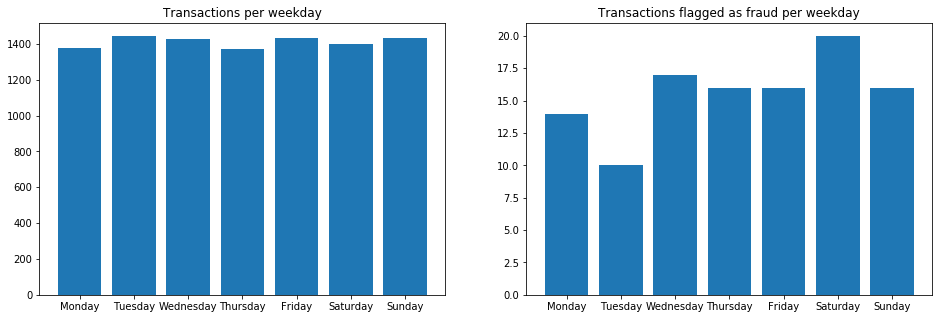

In [99]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
weekdays_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
axs[0].set_title('Transactions per weekday')
aux_weekday = transactions_analysis[(transactions_analysis.fraud_flag == False)].weekday.value_counts()[weekdays_order]
axs[0].bar(aux_weekday.index, aux_weekday.values)
axs[1].set_title('Transactions flagged as fraud per weekday')
aux_weekday_fraud = transactions_analysis[(transactions_analysis.fraud_flag == True)].weekday.value_counts()[weekdays_order]
axs[1].bar(aux_weekday_fraud.index, aux_weekday_fraud.values)
plt.show()

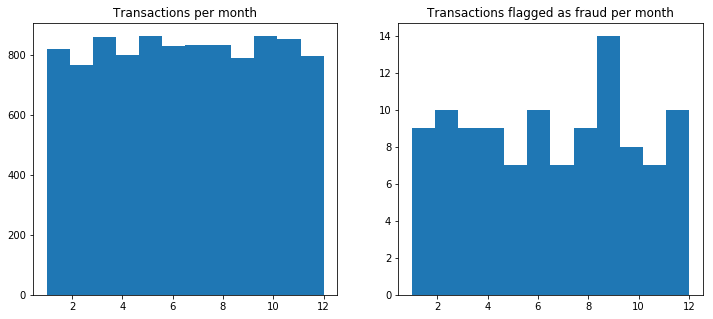

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].set_title('Transactions per month')
axs[0].hist(transactions_analysis[(transactions_analysis.fraud_flag == False)].month, bins=len(transactions_analysis.month.unique()))
axs[1].set_title('Transactions flagged as fraud per month')
axs[1].hist(transactions_analysis[(transactions_analysis.fraud_flag == True)].month, bins=len(transactions_analysis.month.unique()))
plt.show()

Looking at other variables:

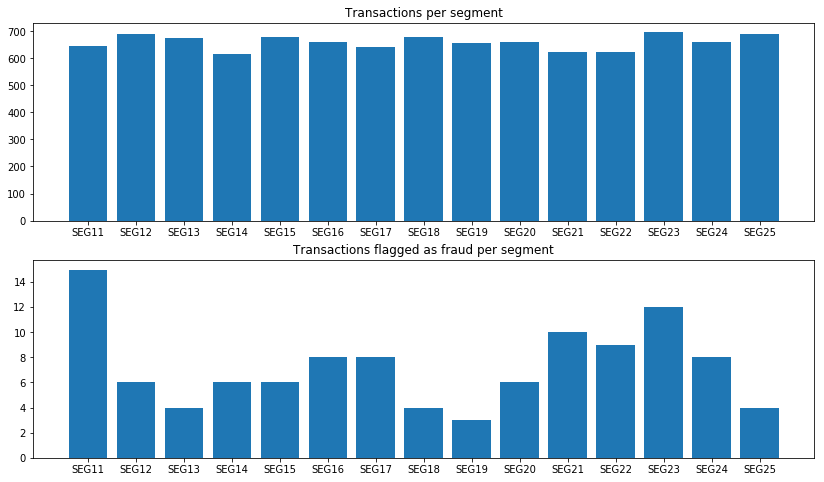

In [105]:
fig, axs = plt.subplots(2, figsize=(14, 8))
axs[0].set_title('Transactions per segment')
aux_segment = transactions_analysis[(transactions_analysis.fraud_flag == False)].segment.value_counts().sort_index()
axs[0].bar(aux_segment.index, aux_segment.values)
axs[1].set_title('Transactions flagged as fraud per segment')
aux_segment_fraud = transactions_analysis[(transactions_analysis.fraud_flag == True)].segment.value_counts().sort_index()
axs[1].bar(aux_segment_fraud.index, aux_segment_fraud.values)
plt.show()

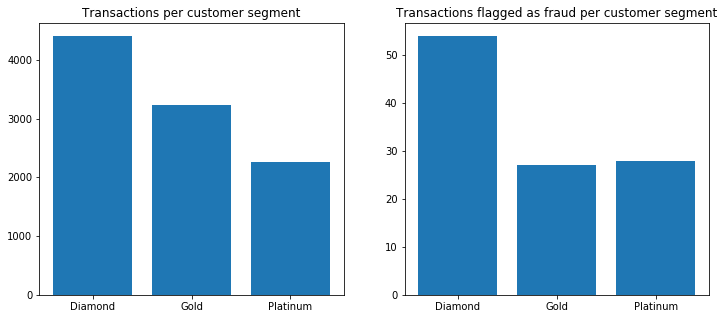

In [110]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].set_title('Transactions per customer segment')
aux_segment_customer = transactions_analysis[(transactions_analysis.fraud_flag == False)].segment_customer.value_counts().sort_index()
axs[0].bar(aux_segment_customer.index, aux_segment_customer.values)
axs[1].set_title('Transactions flagged as fraud per customer segment')
aux_segment_customer_fraud = transactions_analysis[(transactions_analysis.fraud_flag == True)].segment_customer.value_counts().sort_index()
axs[1].bar(aux_segment_customer_fraud.index, aux_segment_customer_fraud.values)
plt.show()

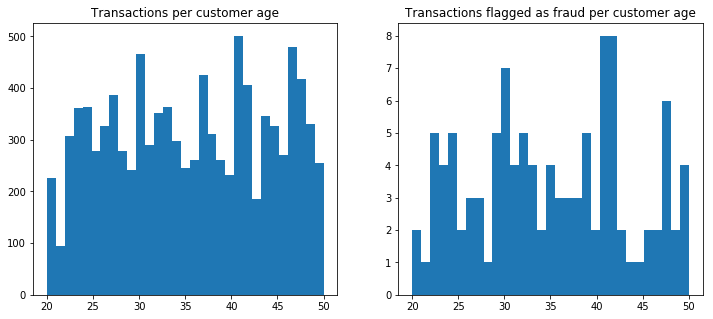

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].set_title('Transactions per customer age')
axs[0].hist(transactions_analysis[(transactions_analysis.fraud_flag == False)].age, bins=len(transactions_analysis.age.unique()))
axs[1].set_title('Transactions flagged as fraud per customer age')
axs[1].hist(transactions_analysis[(transactions_analysis.fraud_flag == True)].age, bins=len(transactions_analysis.age.unique()))
plt.show()

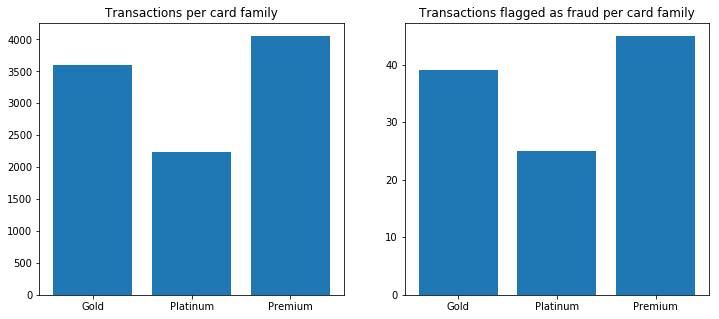

In [113]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].set_title('Transactions per card family')
aux_card_family = transactions_analysis[(transactions_analysis.fraud_flag == False)].card_family.value_counts().sort_index()
axs[0].bar(aux_card_family.index, aux_card_family.values)
axs[1].set_title('Transactions flagged as fraud per card family')
aux_card_family_fraud = transactions_analysis[(transactions_analysis.fraud_flag == True)].card_family.value_counts().sort_index()
axs[1].bar(aux_card_family_fraud.index, aux_card_family_fraud.values)
plt.show()

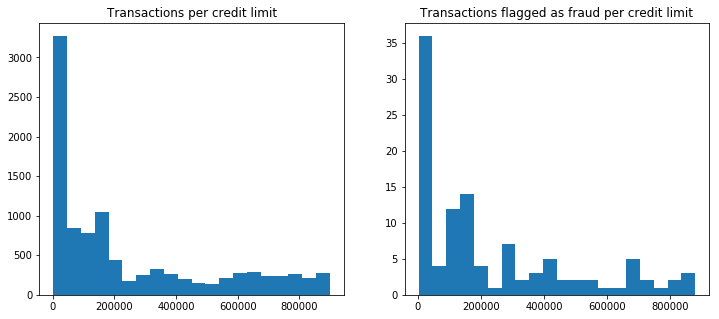

In [115]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].set_title('Transactions per credit limit')
axs[0].hist(transactions_analysis[(transactions_analysis.fraud_flag == False)].credit_limit, bins=20)
axs[1].set_title('Transactions flagged as fraud per credit limit')
axs[1].hist(transactions_analysis[(transactions_analysis.fraud_flag == True)].credit_limit, bins=20)
plt.show()

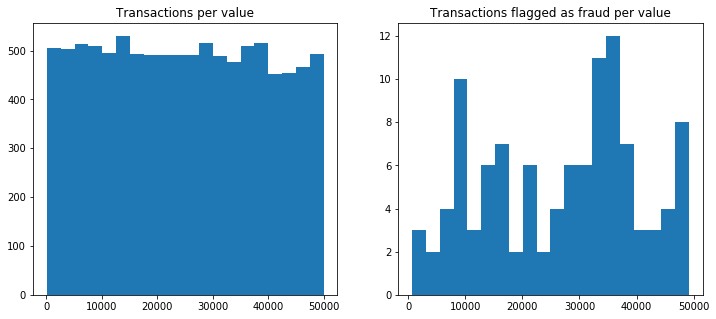

In [116]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].set_title('Transactions per value')
axs[0].hist(transactions_analysis[(transactions_analysis.fraud_flag == False)].value, bins=20)
axs[1].set_title('Transactions flagged as fraud per value')
axs[1].hist(transactions_analysis[(transactions_analysis.fraud_flag == True)].value, bins=20)
plt.show()

In [121]:
(transactions_analysis[transactions_analysis.fraud_flag == True].value/transactions_analysis[transactions_analysis.fraud_flag == True].credit_limit).describe()

count    109.000000
mean       0.838772
std        2.265862
min        0.001958
25%        0.064072
50%        0.184744
75%        0.463200
max       18.353000
dtype: float64

In [122]:
(transactions_analysis[transactions_analysis.fraud_flag == False].value/transactions_analysis[transactions_analysis.fraud_flag == False].credit_limit).describe()

count    9891.000000
mean        0.634669
std         1.569577
min         0.000133
25%         0.049273
50%         0.155547
75%         0.596488
max        24.114500
dtype: float64

In [132]:
transactions_analysis[transactions_analysis.value/transactions_analysis.credit_limit > 1]

,value,segment,fraud_flag,card_family,credit_limit,age,segment_customer,day,weekday,month
18,26726,SEG16,False,Gold,15000,48,Gold,11,Thursday,2
20,28411,SEG15,False,Gold,15000,48,Gold,31,Sunday,1
21,26045,SEG24,False,Gold,15000,48,Gold,6,Monday,6
22,23899,SEG14,False,Gold,15000,48,Gold,6,Saturday,8
23,18018,SEG11,False,Gold,15000,48,Gold,14,Thursday,1
...,...,...,...,...,...,...,...,...,...,...
9959,37522,SEG25,False,Gold,29000,46,Platinum,14,Saturday,5
9962,29125,SEG17,False,Gold,29000,46,Platinum,22,Friday,1
9965,39453,SEG18,False,Gold,29000,46,Platinum,9,Friday,12
9968,47038,SEG11,False,Gold,29000,46,Platinum,22,Friday,1


Two other approaches: use selectKbest then look at feature importance

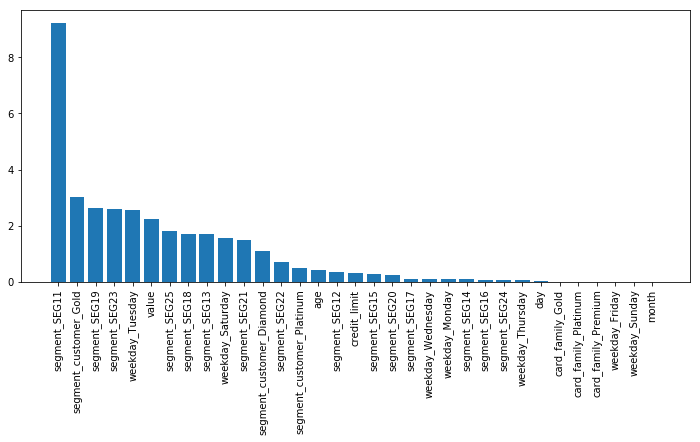

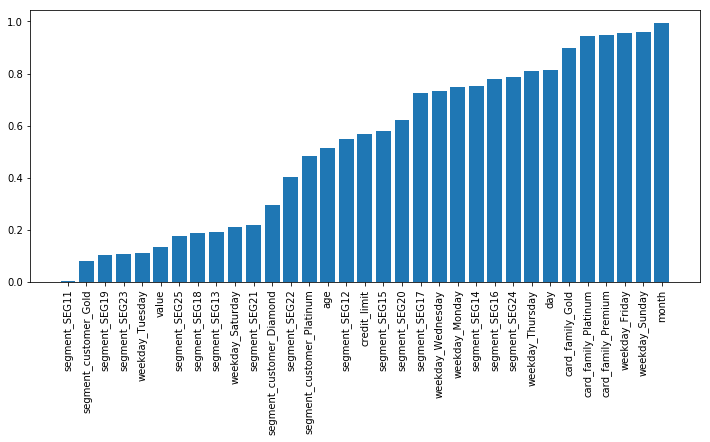

In [183]:
from sklearn.feature_selection import SelectKBest, f_classif

dataset = pd.get_dummies(transactions_analysis)
y = np.array(dataset.pop('fraud_flag'))
X = np.array(dataset.values)

sel = SelectKBest(f_classif, k='all').fit(X, y)

importance_order = np.argsort((-sel.scores_))

plt.figure(figsize=(12, 5))
plt.bar(dataset.columns[importance_order], sel.scores_[importance_order])
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12, 5))
plt.bar(dataset.columns[importance_order], sel.pvalues_[importance_order])
plt.xticks(rotation=90)
plt.show()

In [187]:
dataset.columns[sel.pvalues_ < 0.05]

Index(['segment_SEG11'], dtype='object')

### Conclusions for exercise 2:

